# Bio-Image Analysis Workflow

In this Jupyter Notebook, we develop a complete bio-image analysis workflow for segmenting images into labeled regions, extracting features from those regions, and analyzing the relationships between these features. The data used in this workflow belongs to the BBBC007v1 image set (Jones et al., 2005), available from the Broad Bioimage Benchmark Collection (Ljosa et al., 2012).

## Scientific Tasks
* Develop an image-segmentation workflow
* Extract features from these images
* Visualize relationships between these features
* Analyze feature correlations

## Engineering Tasks
* Setup a software environment
* Setup an image processing workflow
* Setup a data analysis/visualization workflow
* Setup a quality assurance procedure

## Documentation Tasks
* Installation instructions
* User guide
* Documentation of used data
* Explanation of the used algorithms


## Planned Steps:
1. Import necessary libraries
2. Load images and label images
3. Preprocess images
4. Perform image segmentation
5. Extract features from segmented images
6. Visualize relationships between features
7. Analyze correlations between features
8. Perform quality assurance on segmentation results
9. Save results


## Installation Instructions

To ensure a reproducible software environment, install the required libraries using the following commands:

### Using conda:
```
conda create -n bioimage-analysis python=3.9
conda activate bioimage-analysis
conda install numpy pandas matplotlib scikit-image seaborn
pip install stackview the_segmentation_game
```

### Using pip:
```
pip install numpy pandas matplotlib scikit-image seaborn stackview the_segmentation_game
```


In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, filters, measure, segmentation, morphology
import seaborn as sns
import stackview
from the_segmentation_game import metrics


## Load Images and Label Images

Loaded 6 images and 6 label images.


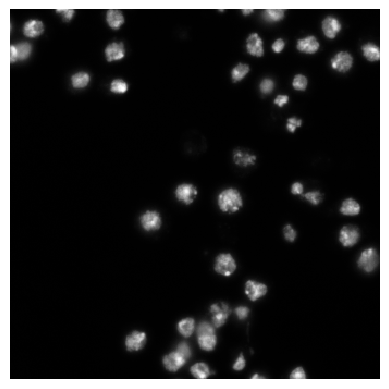

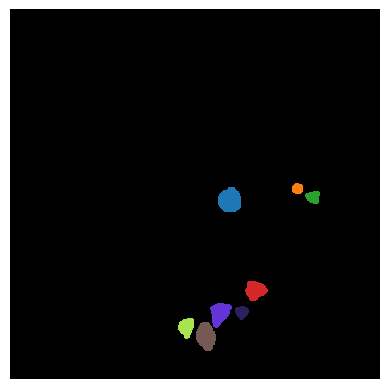

In [2]:
# Load images and label images
image_folder = '../05b_quality_assurance/data/BBBC007_batch/'
label_folder = '../05b_quality_assurance/data/BBBC007_sparse_instance_annotation/'

image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
label_files = [f for f in os.listdir(label_folder) if f.endswith('.tif')]

images = {f: io.imread(os.path.join(image_folder, f)) for f in image_files}
labels = {f: io.imread(os.path.join(label_folder, f)) for f in label_files}

print(f"Loaded {len(images)} images and {len(labels)} label images.")
stackview.imshow(images[image_files[0]])
stackview.imshow(labels[label_files[0]])

## Preprocess Images
Here, we perform basic preprocessing on the images, like normalization and noise reduction.

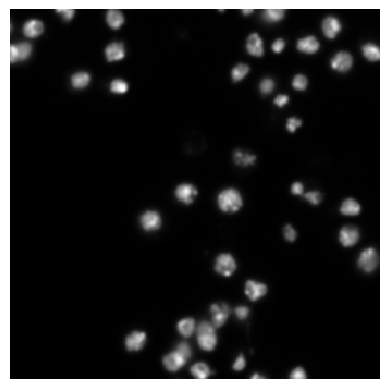

Preprocessing completed.


In [3]:
# Preprocess images: Normalization and noise reduction
preprocessed_images = {}
for img_name, img in images.items():
    # Normalize image
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    # Apply Gaussian filter for noise reduction
    img = filters.gaussian(img, sigma=1)
    preprocessed_images[img_name] = img

stackview.imshow(preprocessed_images[image_files[0]])
print("Preprocessing completed.")

## Perform Image Segmentation
We will use watershed algorithm for image segmentation which helps in separating overlapping objects based on distance transform.

In [4]:
# Perform image segmentation using Watershed algorithm
segmented_images = {}
for img_name, img in preprocessed_images.items():
    # Compute the sobel transform
    edges = filters.sobel(img)
    # Compute the distance transform
    distance = morphology.distance_transform_edt(img)
    local_maxi = measure.label(morphology.local_maxima(distance))
    markers = measure.label(local_maxi)
    segmentation_result = segmentation.watershed(-distance, markers, mask=img)
    segmented_images[img_name] = segmentation_result

stackview.imshow(segmented_images[image_files[0]])
print("Segmentation completed.")

AttributeError: module 'skimage.morphology' has no attribute 'distance_transform_edt'

## Extract Features from Segmented Images
Using region properties from skimage's measure module, we extract features like area, perimeter, eccentricity, etc.

In [ ]:
# Extract features: Area, Perimeter, Eccentricity, Mean Intensity
features_list = []
for img_name, seg in segmented_images.items():
    regions = measure.regionprops(seg, intensity_image=preprocessed_images[img_name])
    for region in regions:
        features = {
            'Image': img_name,
            'Label': region.label,
            'Area': region.area,
            'Perimeter': region.perimeter,
            'Eccentricity': region.eccentricity,
            'Mean Intensity': region.mean_intensity
        }
        features_list.append(features)

features_df = pd.DataFrame(features_list)
display(features_df.head())
print("Feature extraction completed.")

## Visualize Relationships Between Features
Using pair plot visualization to understand relationships.

In [ ]:
# Pair Plot Visualization
sns.pairplot(features_df[['Area', 'Perimeter', 'Eccentricity', 'Mean Intensity']])
plt.show()
print("Pair plot visualization completed.")

## Analyze Correlations Between Features

In [ ]:
# Correlation Analysis
correlation_matrix = features_df[['Area', 'Perimeter', 'Eccentricity', 'Mean Intensity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Correlation Matrix')
plt.show()
print("Correlation analysis completed.")

## Quality Assurance Using Jaccard Index
Computing Jaccard Index for quality check of segmentation.

In [ ]:
# Quality Assurance: Jaccard Index
quality_scores = []
for img_name in image_files:
    if img_name in labels:
        score = metrics.jaccard_index_sparse(labels[img_name], segmented_images[img_name])
        quality_scores.append({'Image': img_name, 'Jaccard Index': score})

quality_df = pd.DataFrame(quality_scores)
display(quality_df)
print("Quality assurance completed.")

## Save Results
Finally, we save the segmented images and feature data to disk.

In [ ]:
# Save results to disk
output_folder = '../segmented/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for img_name, seg in segmented_images.items():
    io.imsave(os.path.join(output_folder, img_name), seg.astype(np.uint16))
features_df.to_csv('../features_extracted.csv', index=False)
print("Results saved.")